# Transfer Learning

世の中にはたくさんの学習済みのモデルがあります。  
このハンズオンでは、それらを使ってTransfer Learningを行っていきます。  
今回は、tensorflow_hubにある学習済みモデルを使います。

## 学習済みモデルの再利用

まずはモデルを読み込み、使用してみます。

In [1]:
!sudo pip install -q -U tf-hub-nightly

In [2]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub

https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4  
今回はこのモデルを使用します。mobile_netは軽量で高速なモデルで、精度もそれなりに高く、非常に使いやすいモデルです。

In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
!pip install pillow

試しに、好きな画像を学習済みモデルでpredictしてみましょう。

image_urlに好きな画像のurlを入れてみてください。

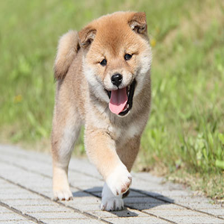

In [5]:
import numpy as np
import PIL.Image as Image

image_url = "https://dol.ismcdn.jp/mwimgs/7/1/670m/img_71c53c1d81500a1cf73a4f543e72413f27838.jpg" # 自分で指定

img = tf.keras.utils.get_file('inu.jpg', image_url)
img = Image.open(img).resize(IMAGE_SHAPE)
img


In [6]:
img = np.array(img) / 255.0
print(img.shape)

(224, 224, 3)


batch_sizeの分だけ次元を増やしてあげてから、predictしてみます。

In [7]:
img = np.expand_dims(img, 0)
result = classifier.predict(img)
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

274

予測結果が得られたので、このclass_idがなんに紐づいているのか定義から確認してみます。

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_name = imagenet_labels[predicted_class]
print(predicted_class_name)

dingo


きちんと学習済みで推論できていることが確認できます。 
他にも何枚か試してみてください。

ロードしたモデルについても確認しておきます。

In [9]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


Trainable params: 0 からこのモデルが再トレーニングできないモデルなことがわかります。

## 最終層を再学習

学習済みモデルを利用することで、様々な物体を高精度に判別することができるモデルを、手軽に用意することが出来ました。  
しかしこのまま利用するには少し問題があります。再トレーニングができないので、このモデルで学習されていない画像が出た時に判別できないのです。

この問題を解決するために、Transfer Learning(転移学習)を行います。  
具体的には、最終層やいくつかの層をあえて取り外し、取り外した部分を再学習させるといったことを行います。  
これによって、学習済みモデルが持つ高精度な判別能力を維持しつつ、自分の問題設定に合わせた判別が可能となります。

では、実際に再学習させてみてTransfer Learningの効果を確認してみましょう。

### データセットの確認

まず、学習に使うデータセットを用意します。

https://www.tensorflow.org/datasets/catalog/overview  
上記のカタログの中から、  
https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet  
こちらのデータセットを今回は使います。

では、このデータセットをローカルに持ってきましょう。

In [10]:
%%bash
DATASET_URL=https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
curl -o images.tar.gz ${DATASET_URL}
tar -xf images.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  20.9M      0  0:00:36  0:00:36 --:--:-- 21.8M


これから使うdataset apiに合わせるため、datasetフォルダの中にペットの種類毎のフォルダを作ってまとめておきます。

In [11]:
DATASET_DIR = "dataset"
for image in os.listdir("images"):
    pet_kind = '_'.join(image.split("_")[:-1])
    os.makedirs(os.path.join(DATASET_DIR, pet_kind), exist_ok=True)
    if image.split(".")[-1] == 'jpg':
        shutil.copy("images/{}".format(image), os.path.join(DATASET_DIR, pet_kind))

dataset apiの一つである[tf.keras.preprocessing.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory?hl=en)を使ってデータセットを読み込みましょう。

In [12]:
image_size = (224, 224)
batch_size = 32
DATASET_DIR = "dataset"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=1111,
    image_size=image_size,
    batch_size=batch_size,
)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=1111,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7390 files belonging to 37 classes.
Using 5912 files for training.
Found 7390 files belonging to 37 classes.
Using 1478 files for validation.


読み込めたら、Fashion-MNISTと同じように画像データがどうなっているかを確認します。  
まず、データの形と、ラベルに何が存在するのかを確認してみましょう。

In [13]:
for images, labels in val_data.take(1):
    print("Image shape (batch, height, width, channel): " + str(images.shape))
    print("Label shape (batch, classes): " + str(labels.shape))
    print("Pet classes: \n" + str(val_data.class_names))

Image shape (batch, height, width, channel): (32, 224, 224, 3)
Label shape (batch, classes): (32, 37)
Pet classes: 
['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


バッチサイズや画像のサイズが指定した数になっていることが確認できると思います。  
また、Fashion-MNISTとは違い、今回のshapeには新たに画像のチャンネルが含まれています。  
ここから、データセットの画像がグレースケールではなく、RGBのカラー画像であることがわかります。

実際に画像を表示してみましょう。

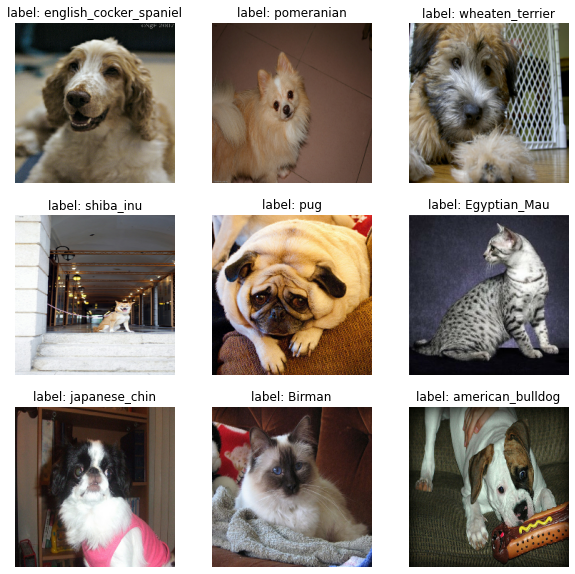

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
def view_dataset():
    for images, labels in val_data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("label: " + val_data.class_names[np.argmax(labels[i])])
            plt.axis("off")
            
view_dataset()

犬や猫の犬種/猫種のカラー画像が表示できたかと思います。

データセット全体の分布も見てみましょう。

<BarContainer object of 37 artists>

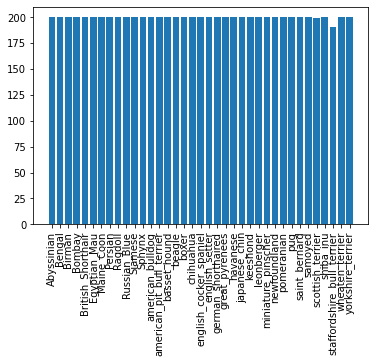

In [15]:
class_names = val_data.class_names
left = range(0, len(class_names))
height = np.zeros(len(class_names))
for data in [train_data, val_data]:
    for _, y in data:
        height += np.sum(y, axis=0)
plt.xticks(rotation=90)
plt.bar(left, height, tick_label=class_names, align="center")

ほとんどのデータが約200枚であることが確認できました。

では、試しにこのデータを先ほどの学習済みモデル、classifierで判別してみましょう。

(32, 1001)
(32, 1001)
(32, 1001)


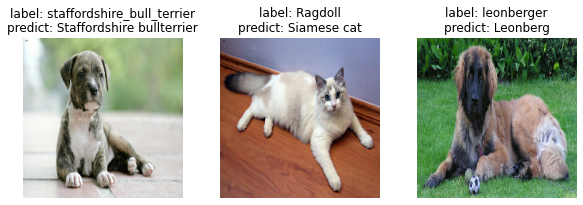

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in val_data.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        norm_images = images / 255
        result = classifier.predict(norm_images)
        print(result.shape)
        predicted_class = np.argmax(result[i], axis=-1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(
            "label: " + val_data.class_names[np.argmax(labels[i])] + 
            "\npredict: " + imagenet_labels[predicted_class]
        )
        plt.axis("off")

何回か繰り返して画像を確認してみてください。  
すると、犬種/猫種を判別できるものと全く判別できないものがあると思います。  
純粋な判別ミスもありますが、ここで理解してもらいたいことは、`classifier(mobilenet)が学習に使用しているImageNetデータセットのクラスに存在しないものは判別できない`ということです。

今回だと
- Havanese
- Wheaten_terrier
- American_Bulldog
- American_Pit_Bull_Terrier
- Bombay 
- Bengal
- Rusian_Blue
- Ragdoll
- British_Shorthair
- Ragdoll
- Abysinian
- Sphynx
- ...

あたりはImageNetに含まれていないので判別できません。    
ImageNetにどういったクラスのものが存在するか興味がある方は、https://starpentagon.net/analytics/ilsvrc2012_class_image/
でチェックしてみると良いです。(公式では現在検索できなくなっているようです。)

こういったものも含めて犬種/猫種を判別できるようにするというのが、Transfer Learningの主目的となります。

### Preprocessing
dataset apiを使ったおかげで、今回はデータのshapeを変える必要はなさそうです。

[tf.keras.layers.experimental.preprocessing.Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling)を用いて正規化だけ行っておきましょう。

In [20]:
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)
norm_train_dataset = train_data.map(lambda x, y: (norm_layer(x), y))
norm_val_dataset = val_data.map(lambda x, y: (norm_layer(x), y))

### モデルの構築
データを用意することができたので、学習に使用するモデルを構築します。

今回はTransfer Learningの有無による精度の差を確認したいので、  
Fashion-MNISTで使った通常のCNNモデルと、Transfer Learningするモデルの二つを構築していきます。

まず、CNNのモデルを定義しましょう。

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

NUM_CLASSES = len(train_data.class_names)

def cnn():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, kernel_size = (3,3), activation = "relu"))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size = (3,3), activation = "relu"))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = "softmax"))
    return model

cnn_model = cnn()

次に、Transfer Learningのモデルを構築します。
特徴量ベクトルが取り出すことができる学習済みモデルを読み込みます。

https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4

ここからurlをコピーして使います。

In [22]:
feature_vector_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMAGE_SHAPE = (224, 224)

def mobilenet_v2():
    model = tf.keras.Sequential([
        hub.KerasLayer(feature_vector_url, input_shape=IMAGE_SHAPE+(3,)),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

transfer_learning_model = mobilenet_v2()
transfer_learning_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 37)                47397     
Total params: 2,305,381
Trainable params: 47,397
Non-trainable params: 2,257,984
_________________________________________________________________


最終層につけたDenseがTrainableで、特徴量ベクトルの層がUntrainableになっていることが確認できるかと思います。  
このTrainable部分を学習させることで、学習モデルにはない犬種/猫種も判別できるモデルにすることができます。

### Training

モデルの構築ができたので、訓練を開始します。

In [23]:
cnn_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'])

In [24]:
transfer_leraning_model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'])

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
を参考に、指標として使いたいlossとaccuracyをbatch毎(step毎)に記録します。

In [25]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.epoch_val_losses = []
        self.epoch_val_acc = []
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['categorical_accuracy'])
        self.model.reset_metrics()
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_val_losses.append(logs['val_loss'])
        self.epoch_val_acc.append(logs['val_categorical_accuracy'])
        self.model.reset_metrics()

In [26]:
batch_stats_callback_cnn = CollectBatchStats()
cnn_model.fit(norm_train_dataset, validation_data=norm_val_dataset, epochs=5, callbacks=[batch_stats_callback_cnn])

Epoch 1/5
185/185 [==============================] - 87s 451ms/step - loss: 3.9076 - categorical_accuracy: 0.0249 - val_loss: 3.6117 - val_categorical_accuracy: 0.0176
Epoch 2/5
185/185 [==============================] - 81s 433ms/step - loss: 3.6131 - categorical_accuracy: 0.0362 - val_loss: 3.6109 - val_categorical_accuracy: 0.0210
Epoch 3/5
185/185 [==============================] - 81s 433ms/step - loss: 3.5005 - categorical_accuracy: 0.0774 - val_loss: 3.5301 - val_categorical_accuracy: 0.0737
Epoch 4/5
185/185 [==============================] - 80s 431ms/step - loss: 2.9242 - categorical_accuracy: 0.2288 - val_loss: 3.6651 - val_categorical_accuracy: 0.0934
Epoch 5/5
185/185 [==============================] - 80s 431ms/step - loss: 1.9605 - categorical_accuracy: 0.4856 - val_loss: 4.2023 - val_categorical_accuracy: 0.0893


In [27]:
batch_stats_callback_transfer_learning = CollectBatchStats()
transfer_learning_model.fit(norm_train_dataset, validation_data=norm_val_dataset, epochs=5, callbacks=[batch_stats_callback_transfer_learning])

Epoch 1/5
185/185 [==============================] - 44s 215ms/step - loss: 0.8390 - categorical_accuracy: 0.7925 - val_loss: 0.3495 - val_categorical_accuracy: 0.8972
Epoch 2/5
185/185 [==============================] - 43s 228ms/step - loss: 0.2482 - categorical_accuracy: 0.9345 - val_loss: 0.2889 - val_categorical_accuracy: 0.9005
Epoch 3/5
185/185 [==============================] - 42s 224ms/step - loss: 0.1641 - categorical_accuracy: 0.9585 - val_loss: 0.2671 - val_categorical_accuracy: 0.9127
Epoch 4/5
185/185 [==============================] - 41s 221ms/step - loss: 0.1192 - categorical_accuracy: 0.9746 - val_loss: 0.2532 - val_categorical_accuracy: 0.9141
Epoch 5/5
185/185 [==============================] - 40s 215ms/step - loss: 0.0910 - categorical_accuracy: 0.9849 - val_loss: 0.2425 - val_categorical_accuracy: 0.9195


### 可視化
訓練が終わったら、各モデルのlossとaccuracyの推移を確認してみます。

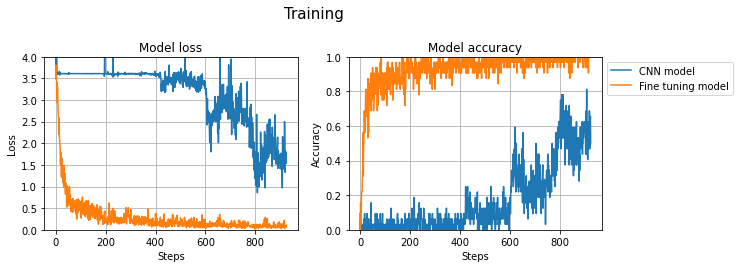

In [28]:
plt.figure(figsize=(10, 7))
plt.suptitle("Training", fontsize=15)
plt.subplot(2, 2, 1)
plt.title('Model loss')
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.ylim([0,4])
plt.plot(batch_stats_callback_cnn.batch_losses, label="CNN model")
plt.plot(batch_stats_callback_transfer_learning.batch_losses, label="Transfer Learning model")
plt.grid()

plt.subplot(2, 2, 2)
plt.title('Model accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback_cnn.batch_acc, label="CNN model")
plt.plot(batch_stats_callback_transfer_learning.batch_acc, label="Transfer Learning model")
plt.grid()

plt.legend(bbox_to_anchor=[1, 1])

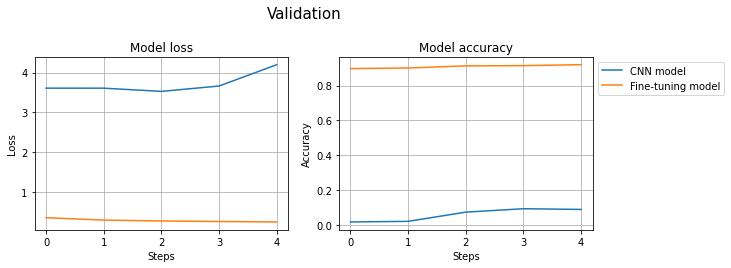

In [29]:
plt.figure(figsize=(10, 7))
plt.suptitle("Validation", fontsize=15)
plt.subplot(2, 2, 1)
plt.title('Model loss')
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.plot(batch_stats_callback_cnn.epoch_val_losses, label="CNN model")
plt.plot(batch_stats_callback_transfer_learning.epoch_val_losses, label="Transfer Learning model")
plt.grid()

plt.subplot(2, 2, 2)
plt.title('Model accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.plot(batch_stats_callback_cnn.epoch_val_acc, label="CNN model")
plt.plot(batch_stats_callback_transfer_learning.epoch_val_acc, label="Transfer Learning model")
plt.grid()

plt.legend(bbox_to_anchor=[1, 1])

両モデルの違いを確認できたでしょうか。

各モデルの個別の予測結果も確認しましょう。  
先程作ったview_datasetメソッドを改良して、ラベルの他にpredictも出力できるようにしましょう。

In [30]:
def view_dataset(model=None):
    for images, labels in val_data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if not model:
                plt.title("label: " + val_data.class_names[np.argmax(labels[i])])
            else:
                norm_img = images / 255
                result = model.predict(norm_img)
                plt.title(
                    "label:" + val_data.class_names[np.argmax(labels[i])] +
                    "\npredict:" + val_data.class_names[np.argmax(result[i])]
                )
            plt.axis("off")

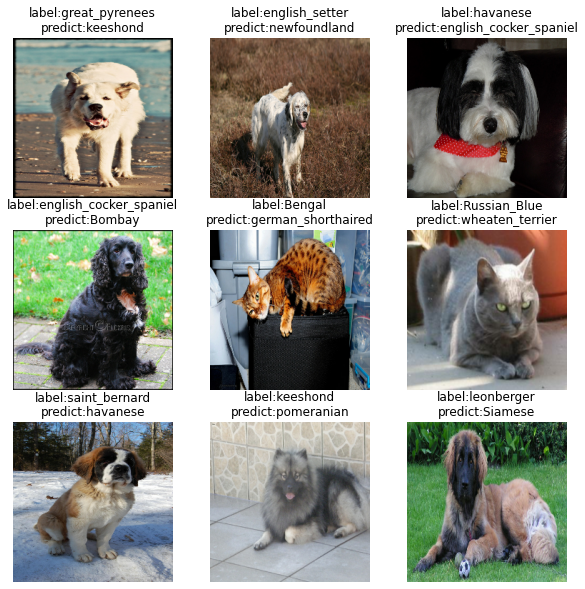

In [31]:
plt.figure(figsize=(10, 10))
view_dataset(cnn_model)

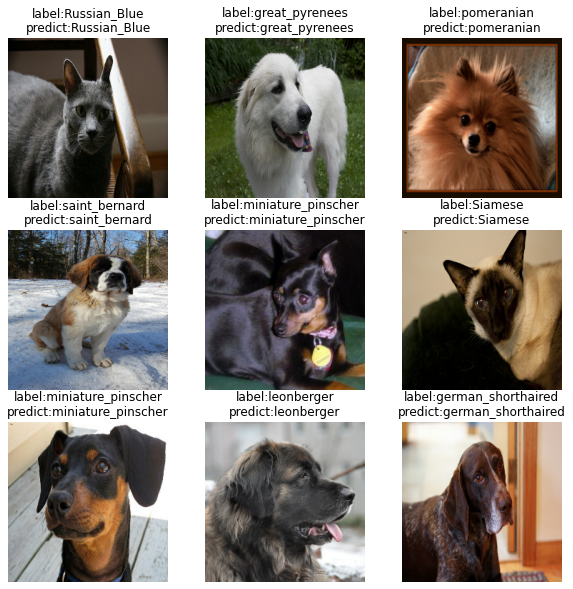

In [37]:
plt.figure(figsize=(10, 10))
view_dataset(transfer_learning_model)

ImageNetデータセットにない犬種/猫種も予測できたでしょうか。